In [30]:
import numpy as np
from scipy.stats import poisson
import logging as logger

In [31]:
class JacksCarRentalEnvironment(object):

    MAX_CAPACITY = 20
    TRANSFER_COST = 2
    REQUEST_RATE = [3, 4]
    RETURN_RATE = [3, 2]
    RENTAL_INCOME = 10

    def step(self, action):
        done = False
        reward = 0
        info = ''

        if(np.min(observation) <= 0):
            done = True
            info = 'No cars!'
        
        if(not done):
            cars_requested_1 = np.random.poisson(REQUEST_RATE[0])
            cars_requested_2 = np.random.poisson(REQUEST_RATE[1])
            observation[0] = observation[0] - cars_requested_1
            observation[1] = observation[1] - cars_requested_2

        if(np.min(observation) <= 0 and not done):
            done = True
            info = 'Not enought cars to fulfill requests!'

        if (not done):
            reward = (cars_requested_1 + cars_requested_2) * RENTAL_INCOME - (abs(action) * TRANSFER_COST)
        else:
            reward = -(abs(action) * 2)
            observation[0] = observation[0] - action
            observation[1] = observation[1] + action
        
        if(not done):
            if(observation[0] - action < 0 and observation[1] + action < 0):
                done = True
                info = 'Not enough cars to move!'
            else:
                observation[0] = observation[0] - action
                observation[1] = observation[1] + action

        cars_returned_1 = np.random.poisson(RETURN_RATE[0])
        cars_returned_2 = np.random.poisson(RETURN_RATE[1])
        observation[0] = observation[0] + cars_returned_1
        observation[1] = observation[1] + cars_returned_2
        np.clip(observation, None, MAX_CAPACITY)

        return observation, reward, False, info

    def reset(self, param=10):
        global observation
        observation = np.array([param, param])
        return observation

    @property
    def action_space(self):
        """
        Returns a Space object
        """
        raise NotImplementedError

    @property
    def observation_space(self):
        """
        Returns a Space object
        """
        raise NotImplementedError

In [32]:
class JacksCarRentalEnvironmentModel(JacksCarRentalEnvironment):
    
    def get_transition_probabilities_and_expected_reward(self, state, action):
        """
            Compute the $p(s', r\mid s,a)$
            Parameters
            ----------
            old_state: tuple of two ints
                the state (cars_at_A, cars_at_B)
            action: int
                nigthly movements of the cars as a int between -5 to 5, e.g.: 
                action +3: move three cars from A to B. 
                action -2: move two cars from B to A.
                
            Returns
            -------
            numpy array (2d - float): mapping from (new) states to probabilities
                index first dimension: cars at A
                index second dimension: cars at B
                value: probability  
            float:  expected reward for the state-action pair
        """
        #assert type(action) == int
        assert np.abs(action) <=5
        # first we move the cars in the night
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
            
        state = self._nightly_moves(state, action)
    
        expected_reward = - type(self).TRANSFER_COST * np.abs(action)
        expected_reward += self._expected_reward_rent(state)
        
        transition_probabilities = self._rent_transition_probabilities(state)
        transition_probabilities = self._returns_transition_probabilities(transition_probabilities)
        return transition_probabilities, expected_reward  
        
        
    def _nightly_moves(self, state, action):
        
        cars_at_A = state[0]
        cars_at_B = state[1]
        if action > 0:
            cars_moved = min(action, cars_at_A)
        else:
            cars_moved = max(action, -cars_at_B)
        
        cars_at_A = min(cars_at_A - cars_moved, type(self).MAX_CAPACITY)
        cars_at_B = min(cars_at_B + cars_moved, type(self).MAX_CAPACITY)
        return [cars_at_A, cars_at_B]
        
    def _expected_reward_rent(self, state):
        expected_reward_rent = 0.
        m = type(self).MAX_CAPACITY+1
        request_mu = type(self).REQUEST_RATE
        for i in (0,1):
            cars_at_loc = state[i]
            rv = scipy.stats.poisson(request_mu[i])
            rent_prob = (rv.pmf(range(m)))
            logger.debug(rent_prob)
            rent_prob[cars_at_loc] = rent_prob[cars_at_loc:].sum()
            rent_prob[cars_at_loc+1:] = 0. 
            logger.debug(rent_prob)
            expected_reward_rent += np.dot(np.arange(len(rent_prob)), rent_prob) * type(self).RENTAL_INCOME
        return expected_reward_rent
        
    def _rent_transition_probabilities(self, state):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m = 15
        n = num_states_for_a_location + 2*m
        p_  = [np.zeros(n), np.zeros(n)]
        request_mu = type(self).REQUEST_RATE
        
        for i in (0,1):
            rv = scipy.stats.poisson(request_mu[i])
            cars_at_loc = state[i]
            x = cars_at_loc + m + 1     
            rent_prob = (rv.pmf(range(x)))
            assert state[i]-x+m+1 == 0
            p_[i][0:cars_at_loc+m+1] = rent_prob[::-1]
            p_[i][m] = p_[i][:m+1].sum()
            p_[i] = p_[i][m:-m]
        return p_
    
    def _returns_transition_probabilities(self, state_probalility):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m=11
        n = num_states_for_a_location + 2*m
        returns_mu = type(self).RETURN_RATE
        p_  = [np.zeros(num_states_for_a_location), np.zeros(num_states_for_a_location)]
        for i in (0,1):
            rv = scipy.stats.poisson(returns_mu[i])
            logger.debug(len(state_probalility[i]))
            for cars_at_loc in range(len(state_probalility[i])):
                p = np.zeros(n)
                logger.debug(p.shape)
                x = num_states_for_a_location - cars_at_loc + m - 1     
                return_prob = (rv.pmf(range(x)))
                logger.debug (p[cars_at_loc+m:-1].shape)
                p[cars_at_loc+m:-1] = return_prob
                logger.debug(return_prob)
                p[num_states_for_a_location+m-1] = p[num_states_for_a_location+m-1:].sum()
                p = p[m:-m]
                logger.debug(p)
                logger.debug(p.sum())
                p_[i] += p * state_probalility[i][cars_at_loc]
        return p_
    

In [33]:
def init_values_and_policy():
    values = np.ones((21, 21))
    policy = np.zeros((21, 21))
    return values, policy

In [34]:
def policy_evaluation(self, values, policy):
    while True:
        delta = 0
        for i in range(len(values)):
            for j in range(len(values[i])):
                v = values[i][j]
                values[i][j] = 0
                delta = argmax(delta, abs(v - values[i][j]))
        # statement(s)
        if delta < param:
            break
    return values, policy

In [35]:
def policy_improvement():
    raise NotImplementedError

In [45]:
model = JacksCarRentalEnvironmentModel()
V,  policy = init_values_and_policy()
model.get_transition_probabilities_and_expected_reward([10,10], 5)

([array([  9.19750147e-03,   3.59582930e-02,   7.76405072e-02,
           1.23652344e-01,   1.59781759e-01,   1.72036462e-01,
           1.54993383e-01,   1.17312637e-01,   7.52599961e-02,
           4.14184193e-02,   1.98074005e-02,   8.33359233e-03,
           3.11951747e-03,   1.04934740e-03,   3.19979499e-04,
           8.91277820e-05,   2.28294074e-05,   5.40896763e-06,
           1.19156524e-06,   2.45184767e-07,   5.76687739e-08]),
  array([  2.69746598e-06,   1.30273937e-05,   4.73734715e-05,
           1.59108029e-04,   4.99498419e-04,   1.45223863e-03,
           3.87992343e-03,   9.45579482e-03,   2.08515054e-02,
           4.12180199e-02,   7.22527799e-02,   1.10924984e-01,
           1.47051374e-01,   1.65751023e-01,   1.56401198e-01,
           1.21975811e-01,   7.82005992e-02,   4.14377557e-02,
           1.83814218e-02,   6.93281151e-03,   3.11105496e-03])],
 58.653730770738719)

In [62]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

def plot3d_over_states(f, zlabel="", ):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # B, A !!!
    B, A = np.meshgrid(B, A)
    V = f.reshape(MAX_CAPACITY+1,-1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(A, B, V, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter(A, B, V, c='b', marker='.')
    ax.set_xlabel("cars at A")
    ax.set_ylabel("cars at B")
    ax.set_zlabel(zlabel)
 
    #ax.view_init(elev=10., azim=10)
    
    plt.show()

In [63]:
def plot_policy(policy):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(-5,6,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po, levels)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Policy')
    plt.xlabel("cars at B")
    plt.ylabel("cars at A")

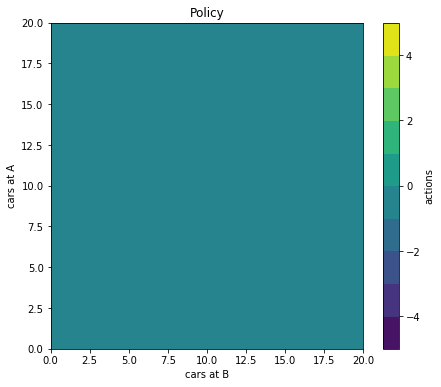

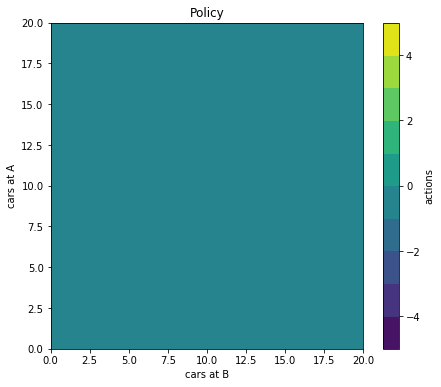

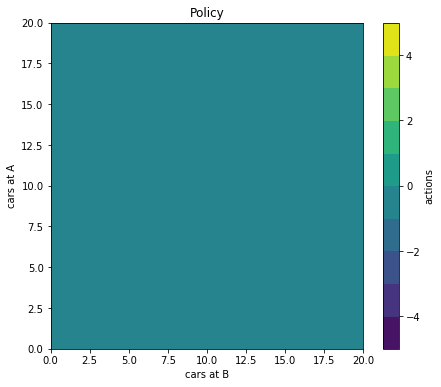

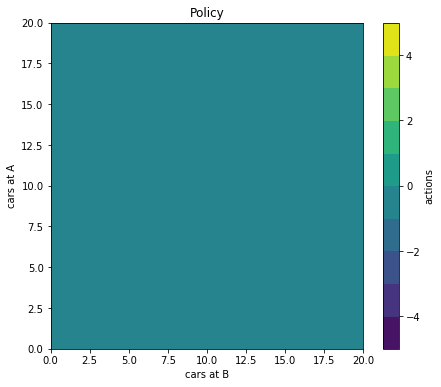

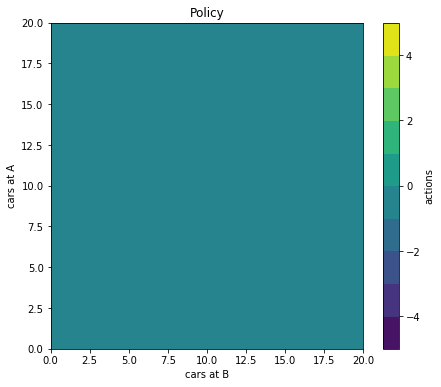

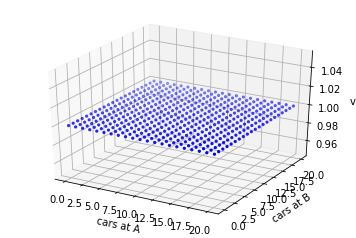

In [64]:
plot3d_over_states(V, 'v')

In [65]:
plot_policy(policy)

In [60]:
plot3d_over_states(V)

NameError: global name 'MAX_CAPACITY' is not defined

In [61]:
plot_policy(policy)